In [5]:
import requests
import os
import pandas as pd
from dotenv import  load_dotenv

load_dotenv()

# Alpha Vantage API Key and URL
API_KEY = os.getenv("ALPHA_VANTAGE")
BASE_URL = "https://www.alphavantage.co/query"

# Stock Symbol and Parameters
stock_symbol = "AAPL"  # Example: Apple
params = {
    "function": "TIME_SERIES_DAILY",  # Free endpoint
    # "function": "TIME_SERIES_DAILY_ADJUSTED", # premium
    "symbol": stock_symbol,
    # "outputsize": "compact",  # Fetch recent 100 data points
    "outputsize": "full", # my processing power is limited 
    "apikey": API_KEY
}

# Fetch Data
response = requests.get(BASE_URL, params=params)
# print(response.json())
data = response.json()

# Process Data
time_series = data["Time Series (Daily)"]
df = pd.DataFrame.from_dict(time_series, orient="index")
df = df.rename(columns={
    "1. open": "Open",
    "2. high": "High",
    "3. low": "Low",
    "4. close": "Close",
    "5. adjusted close": "Adj Close",
    "6. volume": "Volume"
}).astype(float)
df.index = pd.to_datetime(df.index)
df = df.sort_index()  # Sort by date

# Save to CSV
df.to_csv("../data/apple_stock_data.csv")
display(df.head())
print('success')


,Open,High,Low,Close,5. volume
1999-11-01,80.00,80.69,77.37,77.62,2487300.0
1999-11-02,78.00,81.69,77.31,80.25,3564600.0
1999-11-03,81.62,83.25,81.00,81.50,2932700.0
1999-11-04,82.06,85.37,80.62,83.62,3384700.0
1999-11-05,84.62,88.37,84.00,88.31,3721500.0


success


In [16]:
import pandas as pd

df = pd.read_csv('../data/apple_stock_data.csv', index_col=0)
df.head()

,Open,High,Low,Close,Volume
1999-11-01,80.00,80.69,77.37,77.62,2487300.0
1999-11-02,78.00,81.69,77.31,80.25,3564600.0
1999-11-03,81.62,83.25,81.00,81.50,2932700.0
1999-11-04,82.06,85.37,80.62,83.62,3384700.0
1999-11-05,84.62,88.37,84.00,88.31,3721500.0


In [17]:
# Check for missing values
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

### stock prices and identify trends over time

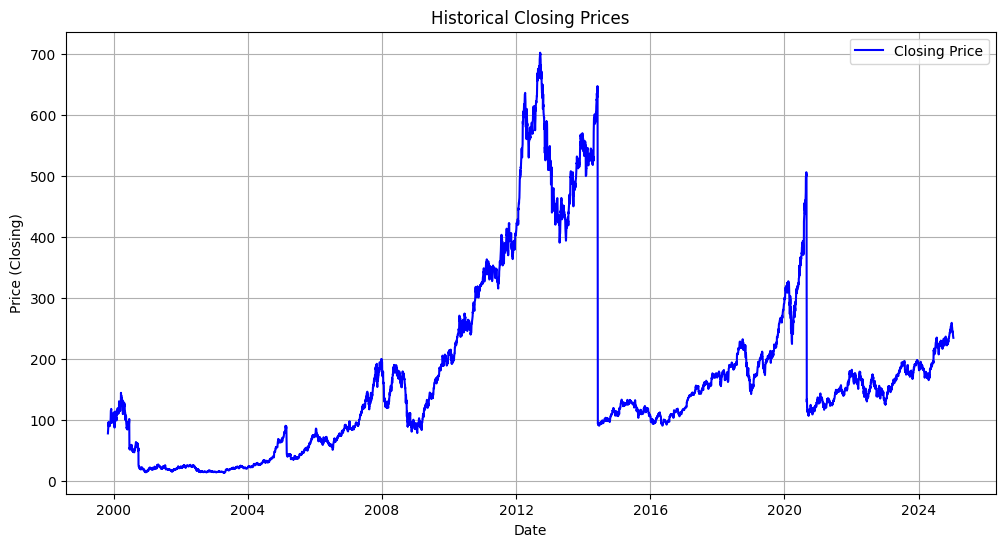

In [8]:
import matplotlib.pyplot as plt

# historical closing prices over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Close"], label="Closing Price", color="blue")
plt.title("Historical Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price (Closing)")
plt.legend()
plt.grid()
plt.show()


In [9]:
df.index

DatetimeIndex(['1999-11-01', '1999-11-02', '1999-11-03', '1999-11-04',
               '1999-11-05', '1999-11-08', '1999-11-09', '1999-11-10',
               '1999-11-11', '1999-11-12',
               ...
               '2024-12-27', '2024-12-30', '2024-12-31', '2025-01-02',
               '2025-01-03', '2025-01-06', '2025-01-07', '2025-01-08',
               '2025-01-10', '2025-01-13'],
              dtype='datetime64[ns]', length=6339, freq=None)

### Analyze Seasonality and Trends
Use a rolling average to smooth the data and observe trends.<br>
Note (googled):<br>
A rolling average continuously updates the average of a data set to include all the data in the set until that point. For example, the rolling average of return quantities at March 2012 would be calculated by adding the return quantities in January, February, and March, and then dividing that sum by three.<br><br>
Simple Moving Average (SMA):<br>
It is simply the average price over the specified period. The average is called "moving" because it is plotted on the chart bar by bar, forming a line that moves along the chart as the average value changes. SMAs are often used to determine trend direction.

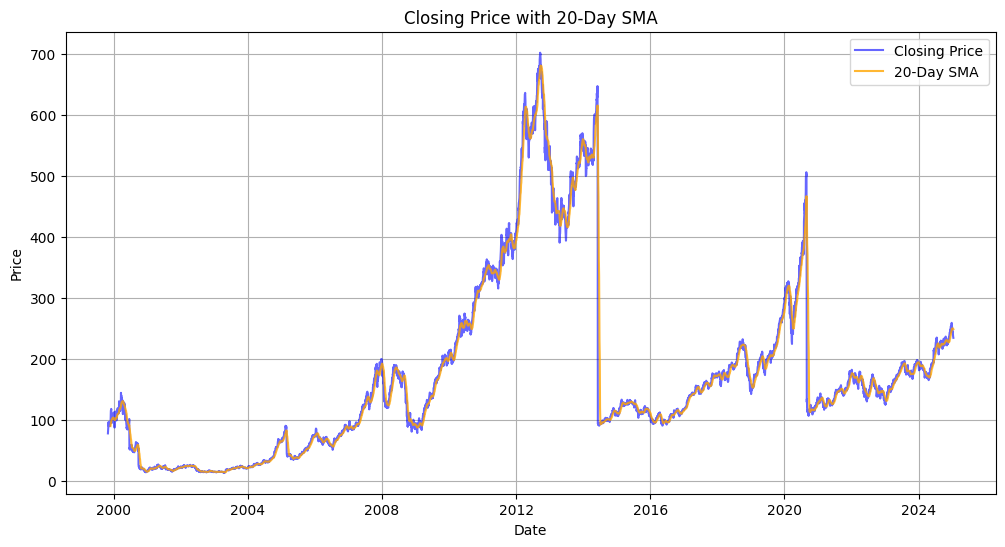

In [10]:
# Calculate a 20-day rolling average
df["20-Day SMA"] = df["Close"].rolling(window=20).mean()

# Plot Closing Price and 20-Day SMA
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Close"], label="Closing Price", color="blue", alpha=0.6)
plt.plot(df.index, df["20-Day SMA"], label="20-Day SMA", color="orange", alpha=0.8)
plt.title("Closing Price with 20-Day SMA")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()


In [16]:
df["20-Day SMA"]
# the dates are the index

1999-11-01         NaN
1999-11-02         NaN
1999-11-03         NaN
1999-11-04         NaN
1999-11-05         NaN
                ...   
2025-01-06    249.9850
2025-01-07    249.9535
2025-01-08    249.7510
2025-01-10    249.2050
2025-01-13    248.6005
Name: 20-Day SMA, Length: 6339, dtype: float64

### Autocorrelation and Partial Autocorrelation
Use ACF and PACF plots to analyze the dependency between observations.

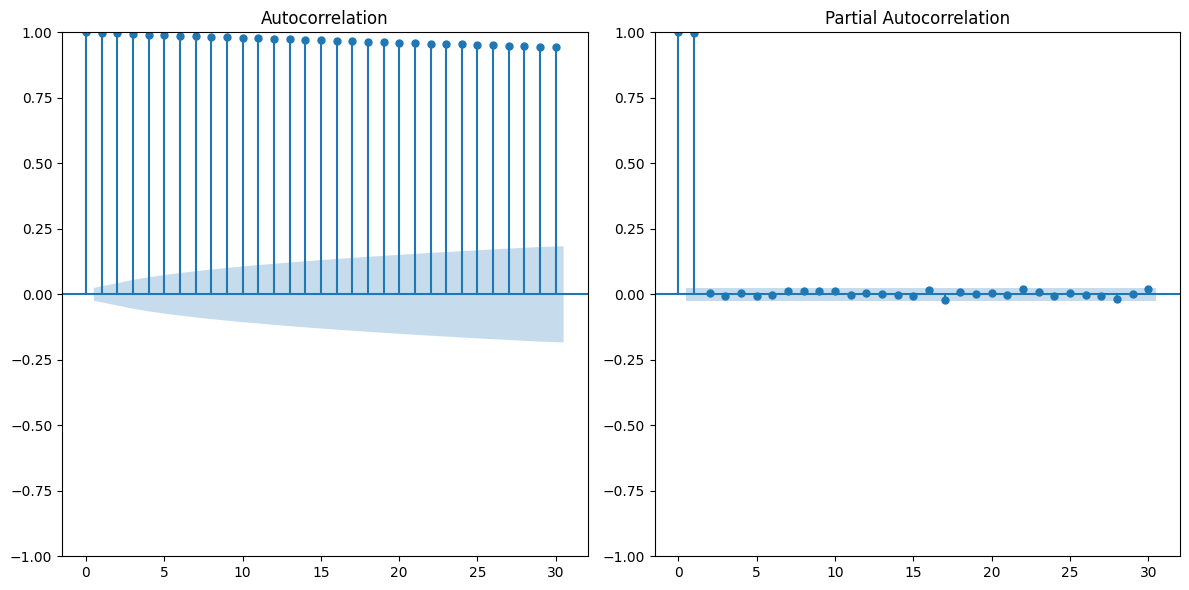

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plot_acf(df["Close"], lags=30, ax=plt.subplot(121))
plot_pacf(df["Close"], lags=30, ax=plt.subplot(122))
plt.tight_layout()
plt.show()

In [4]:
# Fill missing values using forward fill
df = df.fillna(method="ffill")

/var/folders/36/p69p4q6n5g59bwgs2qlvc69h0000gn/T/ipykernel_710/185862678.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill")


### Feature Engineering
Generate lag features and technical indicators to enhance model input. <br>
This code snippet is part of feature engineering in time series analysis. It generates lag features and calculates common technical indicators such as Bollinger Bands and Relative Strength Index (RSI). These features are useful for understanding patterns in stock prices and improving predictive models.

In [6]:
# Lag Features
# Lag features represent the stock price from 1 and 2 days prior.
# These are used to model temporal dependencies in the data.
# shift(1): Moves the values of the "Close" column down by one row.
df["Lag_1"] = df["Close"].shift(1)
df["Lag_2"] = df["Close"].shift(2)

# Bollinger Bands
# Bollinger Bands are a popular technical indicator used to identify price volatility.
# Rolling Mean: The average price over a moving window (20 days in this case).
# Rolling Std: The standard deviation of prices over the same window.
# Upper BB: Two standard deviations above the rolling mean.
# Lower BB: Two standard deviations below the rolling mean.
df["Rolling_Mean"] = df["Close"].rolling(window=20).mean()
df["Rolling_Std"] = df["Close"].rolling(window=20).std()
df["Upper_BB"] = df["Rolling_Mean"] + (df["Rolling_Std"] * 2)
df["Lower_BB"] = df["Rolling_Mean"] - (df["Rolling_Std"] * 2)

# Relative Strength Index (RSI)
# delta: Difference between today’s and yesterday’s closing prices.
# gain: Average of positive price changes over a 14-day window.
# loss: Average of negative price changes over a 14-day window.
# rs: The ratio of average gain to average loss.
# RSI: Converts the rs ratio into a 0–100 scale.
window = 14
delta = df["Close"].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
rs = gain / loss
df["RSI"] = 100 - (100 / (1 + rs))
# RSI above 70 suggests overbought conditions (price may fall).
# RSI below 30 suggests oversold conditions (price may rise).

In [11]:
df[['Close', 'RSI', 'Rolling_Mean', 'Rolling_Std', 'Upper_BB', 'Lower_BB']]

,Close,RSI,Rolling_Mean,Rolling_Std,Upper_BB,Lower_BB
1999-11-01,77.62,NaN,NaN,NaN,NaN,NaN
1999-11-02,80.25,NaN,NaN,NaN,NaN,NaN
1999-11-03,81.50,NaN,NaN,NaN,NaN,NaN
1999-11-04,83.62,NaN,NaN,NaN,NaN,NaN
1999-11-05,88.31,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2025-01-06,245.00,45.992318,249.9850,4.831496,259.647992,240.322008
2025-01-07,242.21,38.659132,249.9535,4.882317,259.718135,240.188865
2025-01-08,242.70,35.424554,249.7510,5.101260,259.953520,239.548480
2025-01-10,236.85,35.026738,249.2050,5.853399,260.911798,237.498202


### Normalize and scale data

In [18]:
from sklearn.preprocessing import MinMaxScaler

# Select columns to scale
features_to_scale = ["Open", "High", "Low", "Close", "Volume"]
scaler = MinMaxScaler()

# Scale features and add them back to the DataFrame
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

### train-test split

### Model selection:
first we train models with simple algorithms for benchmarking. <br>
### Naive Forecasting: Last Value Prediction
Naive forecasting is a simple yet effective baseline model. It predicts the next value in the time series as the last observed value. This method is often used to benchmark the performance of more complex models.

In [20]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# The 'Close' column contains the target variable (closing prices)
df = df.dropna()  # Ensure there are no missing values

# Split into train and test sets (80-20)
# Note: the data of such nature is not supposed to be splitted by test_train_split method
train_size = int(len(df) * 0.8)  
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# Naive Forecasting
# Predict the next values as the last observed value from the training set
last_value = train["Close"].iloc[-1]  # Last value from training data
test["Naive_Prediction"] = last_value  # Use the last value for all predictions

# Evaluate the Performance
mae = mean_absolute_error(test["Close"], test["Naive_Prediction"])
mse = mean_squared_error(test["Close"], test["Naive_Prediction"])
rmse = np.sqrt(mse)

print(f"Naive Forecasting Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Naive Forecasting Performance:
Mean Absolute Error (MAE): 0.17
Mean Squared Error (MSE): 0.03
Root Mean Squared Error (RMSE): 0.18


/var/folders/36/p69p4q6n5g59bwgs2qlvc69h0000gn/T/ipykernel_710/3409034555.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Naive_Prediction"] = last_value  # Use the last value for all predictions


In [ ]:
import matplotlib.pyplot as plt

# Naive Forecasting performance
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["Close"], label="Training Data")
plt.plot(test.index, test["Close"], label="Actual Test Data")
plt.plot(test.index, test["Naive_Prediction"], label="Naive Forecast", linestyle="--")
plt.legend()
plt.title("Naive Forecasting vs Actual Test Data")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()
